###  Created by Luis A. Sanchez-Perez (alejand@umich.edu)

### Description

You are given the dataset in data.csv. This contains a column per keyword of interest (words are in Spanish) where each row represents an observation of an identification document (either passport, IFE (equivalent to what we know as Michigan ID), or driver's license). The last column represents the type of document of that observation. The text recognized by the OCR is encoded in this dataset using [edit distance](https://en.wikipedia.org/wiki/Edit_distance), where the value of each column represents what was the smallest edit distance we found to that particular keyword in the all the text recognized.

In this homework you will implement a Naive Bayes classifier from scratch and compare your results with the implementation from the sklearn library.

### Place all imports here

In [34]:
import numpy as np
import pandas as pd
from scipy.special import logsumexp
import seaborn as sn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

### 1. Load dataset

In [35]:
# IMPORT DATA
data_set = pd.read_csv("data.csv")
is_ife = data_set.loc[data_set['type'] == "IFE"]
is_licencia = data_set.loc[data_set['type'] == "Licencia"]
is_pasaporte = data_set.loc[data_set['type'] == "Pasaporte"]

### 2. Observations per class
Generate a count plot of observations per class. You can use matplotlib or seaborn for plotting. Any is fine.

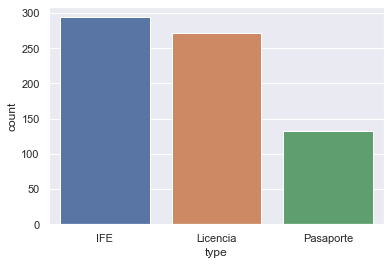

In [36]:
# Generate count plot
sn.set(style="darkgrid")
ax = sn.countplot(x="type", data=data_set)

### 2. Frequency of each word per class
Generate a frequency chart (bar plot) showing the frequency of each word per class. You must generate a chart per class. You can use matplotlib or seaborn for plotting. Any is fine.

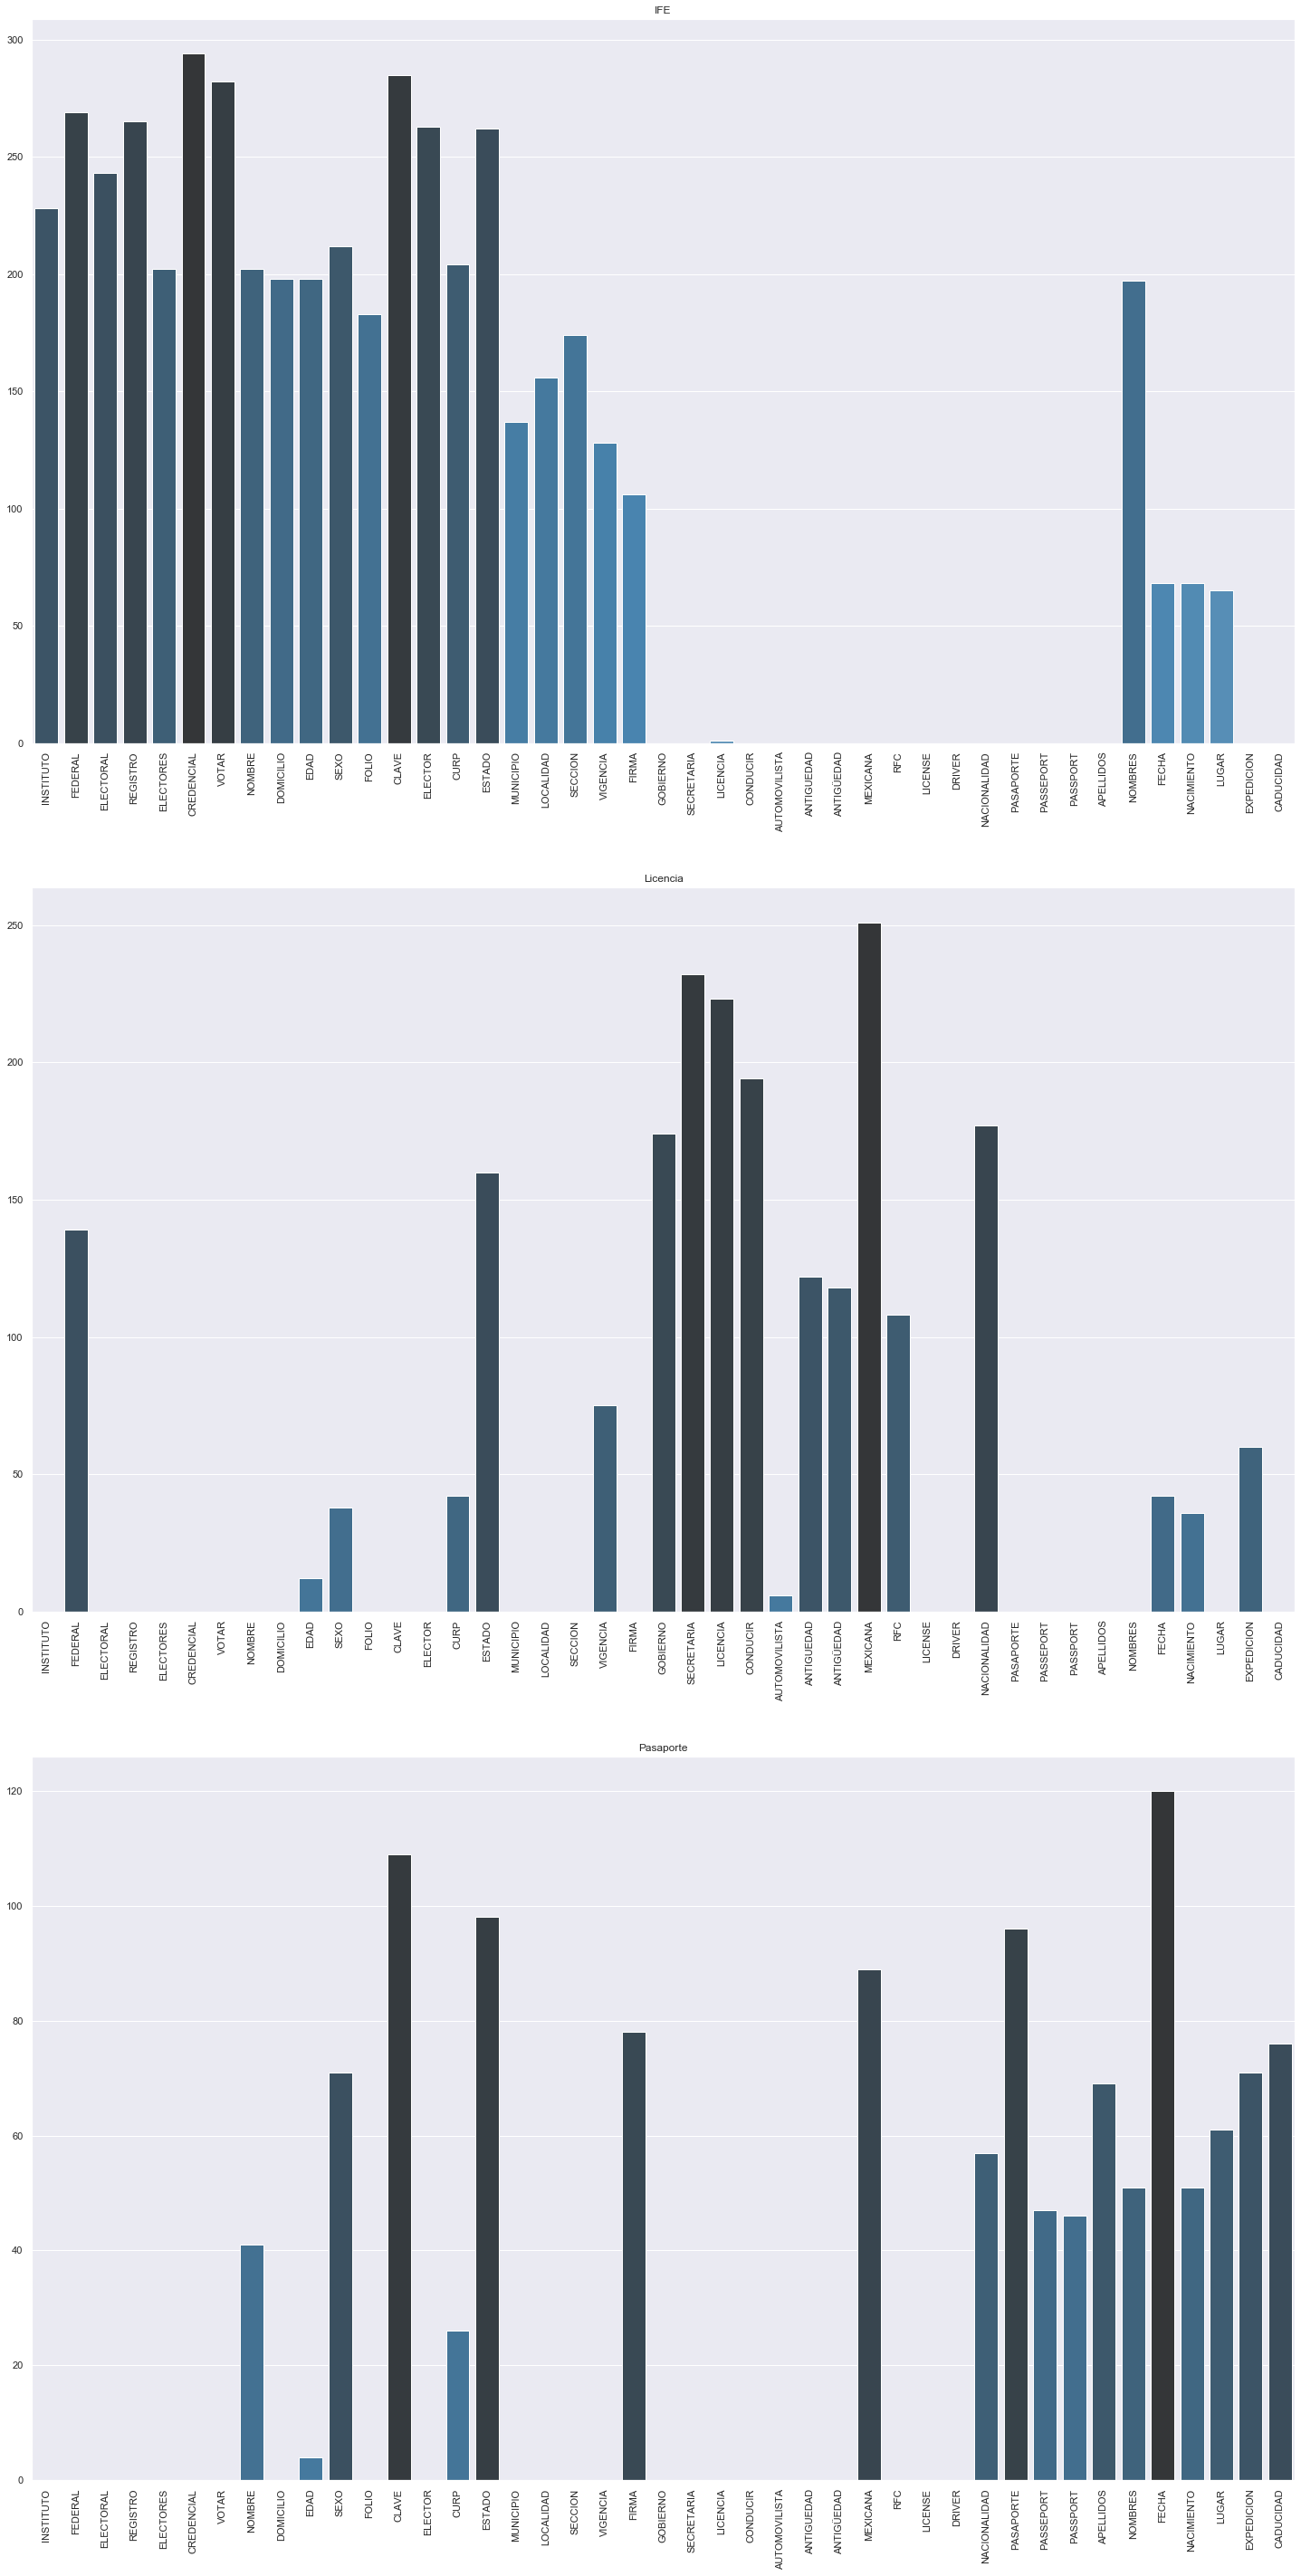

In [37]:
columns = data_set.columns
plt.figure(figsize=(25,50))
classes = list(["IFE", "Licencia", "Pasaporte"])
for i in list([0, 1, 2]):
    first_filter = data_set.loc[data_set['type'] == classes[i]]
    first_filter_boolean = first_filter.eq(0).astype(int)[columns[0:-1]] + first_filter.eq(1).astype(int)[
        columns[0:-1]]
    values = sum(first_filter_boolean.values)
    plt.subplot(3, 1, i+1)
    pal = sn.color_palette("Blues_d", len(values))
    rank = values.argsort().argsort()
    fig = sn.barplot(x=columns[0:len(columns) - 1], y=values, palette=np.array(pal[::-1])[rank])
    plt.xticks(rotation=90)
    plt.title(classes[i])

### 3. Properly train and test a multinomial naive bayes classifier
Use sklearn implementation. Generate the confusion matrix for both training and test sets and compute the accuracy as well.

Accuracy Score = 1.0
Confusion Matrix = [[30  0  0]
 [ 0 27  0]
 [ 0  0 13]]


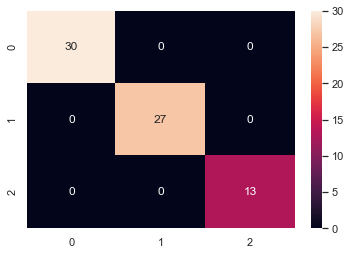

In [38]:
# Create Data for Sklearn implementation
features = list(range(43))
X = data_set.iloc[:, features].values
y = data_set.iloc[:, 43].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

# Train Classifier
classifier = CategoricalNB()
classifier.fit(X_train, y_train)

# Test Classifier
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("Accuracy Score =",acc)
print("Confusion Matrix =",cm)
sn.heatmap(cm, annot=True, fmt='g')

### 4. Evaluate point
Compute the probabilities outputted by the model for the `point` defined below

In [39]:
# Do not modify this cell
point = np.array([3, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 3, 3, 3, 3, 3, 3, 
                  0, 3, 3, 2, 3, 0, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3], ndmin=2)

In [40]:
y_pred_PointProb = classifier.predict_proba(point)
print("Predicted Probabilities =",y_pred_PointProb)

Predicted Probabilities = [[1.00000000e+00 2.91442353e-20 4.41179214e-15]]


### 5. Compute log-likelihood
Assuming multinomial features and therefore multinomial distributions compute the likelihood of the `point` given above using Laplace smoothing. Notice you need to get three values, a likelihood value per class.

I recommend using a dict to store the probabilities per class. For instance, using a dictionary where the key is the class and the value is an array of size [**size of the domain of the features** x **number of features**] (in this case 4x43)

You can also use a 3-dimensional matrix of size [**number of classes** x **size of the domain of the features** x **number of features**] (in this case 3x4x43)

In [41]:
# Generate Matrix of Probabilities
LL_ff = np.array([[None] * 43] * 4)
LL = np.array([[[None] * 43] * 4] * 3)
alpha = 1
G = 4
classes = list(["IFE", "Licencia", "Pasaporte"])
for i in list([0, 1, 2]):
    first_filter = X_train[y_train == classes[i]]
    length_ff = len(first_filter)
    for j in list([0, 1, 2, 3]):
        second_filter = (first_filter == j).astype(int)
        prob_sf = ((sum(np.array(second_filter)))+alpha)/(length_ff+(alpha*G))
        LL_ff[j, :] = prob_sf
    LL[i, :, :] = LL_ff
    
# Evaluate Point
classes = list(["IFE", "Licencia", "Pasaporte"])
prob_vector = np.array([[None] * 43] * 1)
likelihood_vector = np.array([[None] * 3] * 1)
for i in list([0, 1, 2]):
    for j in list(range(43)):
        value = point[0, j]
        prob_vector[0, j] = LL[i, value, j]
    likelihood_vector[0, i] = np.prod(prob_vector)
    
print("Log-Likelihood Vector =",likelihood_vector)

Log-Likelihood Vector = [[1.3260639621345676e-24 4.1644243773882036e-44 1.297885799528814e-38]]


### 6. Compute the priors
Use frequency analysis to estimate this

In [42]:
classes = list(["IFE", "Licencia", "Pasaporte"])
prior_vector = np.array([[None] * 3] * 1)
for i in list([0, 1, 2]):
    first_filter = y_train[y_train == classes[i]]
    length_ff = len(first_filter)
    length_total = len(y_train)
    prior_vector[0, i] = length_ff/length_total
    
print("Prior Vector =",prior_vector)

Prior Vector = [[0.42038216560509556 0.39012738853503187 0.18949044585987262]]


### 7. Compute the log-posterior and posterior
Manually compute the log-posterior and posterior probability for the given `point` above using your log-likelihood and prior computations. Use the `logsumexp` trick to make your computation safer. Your posterior should be similar to the values obtained with the trained model but not necessarily equal.

In [43]:
# Compute posterior and log-posterior
posterior_vector = np.array([[None] * 3] * 1)
log_posterior_vector = np.array([[None] * 3] * 1)
bi = [np.log(likelihood_vector[0, i] * prior_vector[0, i]) for i in list([0, 1, 2])]
B = max(bi)
ln_evidence = B + logsumexp(bi-B)
for i in list([0, 1, 2]):
    log_posterior_vector[0, i] = np.log(likelihood_vector[0, i]) + np.log(prior_vector[0, i]) - ln_evidence
    posterior_vector[0, i] = math.exp(log_posterior_vector[0, i])
    
print("Log-Posterior Vector =",log_posterior_vector)
print("Posterior Vector =",posterior_vector)

Log-Posterior Vector = [[-1.4210854715202004e-14 -44.98202981862777 -33.05449540691739]]
Posterior Vector = [[0.9999999999999858 2.9144235325370765e-20 4.411792140584718e-15]]


### 8. Compute performance of your custom implementation (training/test)

Compute the performance of your custom model for the training and test set printing the confusion matrix and accuracy score for each case.

#### Training Set:

Accuracy Score = 1.0
Confusion Matrix = [[264   0   0]
 [  0 245   0]
 [  0   0 119]]


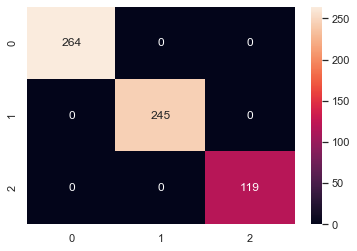

In [44]:
# Accuracy metrics for training set
y_pred_train = np.array([[None] * len(X_train)] * 1)
for i in range(len(X_train)):
    point = X_train[i, :]

    classes = list(["IFE", "Licencia", "Pasaporte"])
    prob_vector = np.array([[None] * 43] * 1)
    likelihood_vector = np.array([[None] * 3] * 1)
    for j in list([0, 1, 2]):
        for k in list(range(43)):
            value = point[k]
            prob_vector[0, k] = LL[j, value, k]
        likelihood_vector[0, j] = np.prod(prob_vector)

    posterior_vector = np.array([[None] * 3] * 1)
    log_posterior_vector = np.array([[None] * 3] * 1)
    bi = [np.log(likelihood_vector[0, i] * prior_vector[0, i]) for i in list([0, 1, 2])]
    B = max(bi)
    ln_evidence = B + logsumexp(bi - B)
    for l in list([0, 1, 2]):
        # posterior_vector[0, i] = (likelihood_vector[0, i]*prior_vector[0, i]) / evidence
        log_posterior_vector[0, l] = np.log(likelihood_vector[0, l]) + np.log(prior_vector[0, l]) - ln_evidence
        posterior_vector[0, l] = math.exp(log_posterior_vector[0, l])

    y_pred_train[0, i] = classes[np.argmax(posterior_vector)]

cm_train = confusion_matrix(y_train, y_pred_train[0, :])
acc_train = accuracy_score(y_train, y_pred_train[0, :])

print("Accuracy Score =",acc_train)
print("Confusion Matrix =",cm_train)
sn.heatmap(cm_train, annot=True, fmt='g')

#### Test Set:

Accuracy Score = 1.0
Confusion Matrix = [[30  0  0]
 [ 0 27  0]
 [ 0  0 13]]


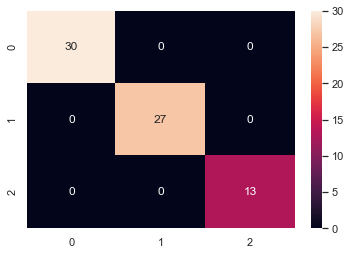

In [45]:
# Accuracy metrics for test set
y_pred_test = np.array([[None] * len(X_test)] * 1)
for i in range(len(X_test)):
    point = X_test[i, :]

    classes = list(["IFE", "Licencia", "Pasaporte"])
    prob_vector = np.array([[None] * 43] * 1)
    likelihood_vector = np.array([[None] * 3] * 1)
    for j in list([0, 1, 2]):
        for k in list(range(43)):
            value = point[k]
            prob_vector[0, k] = LL[j, value, k]
        likelihood_vector[0, j] = np.prod(prob_vector)

    posterior_vector = np.array([[None] * 3] * 1)
    log_posterior_vector = np.array([[None] * 3] * 1)
    bi = [np.log(likelihood_vector[0, i] * prior_vector[0, i]) for i in list([0, 1, 2])]
    B = max(bi)
    ln_evidence = B + logsumexp(bi - B)
    for l in list([0, 1, 2]):
        # posterior_vector[0, i] = (likelihood_vector[0, i]*prior_vector[0, i]) / evidence
        log_posterior_vector[0, l] = np.log(likelihood_vector[0, l]) + np.log(prior_vector[0, l]) - ln_evidence
        posterior_vector[0, l] = math.exp(log_posterior_vector[0, l])

    y_pred_test[0, i] = classes[np.argmax(posterior_vector)]

cm_test = confusion_matrix(y_test, y_pred_test[0, :])
acc_test = accuracy_score(y_test, y_pred_test[0, :])

print("Accuracy Score =",acc_test)
print("Confusion Matrix =",cm_test)
sn.heatmap(cm_test, annot=True, fmt='g')